# 07 Pretrained Convnets
**Adapted from Deep Learning with Pyton by Francois Chollet**

https://github.com/fchollet/deep-learning-with-python-notebooks

## Using a Pre-trained Convnet

A pre-trained network is simply a saved network previously trained on a large dataset, typically on a large-scale image classification task. For instance, one might train a network on ImageNet (where classes are mostly animals and everyday objects) and then re-purpose this trained network for something as remote as identifying furniture items in images. 

We will consider a large convnet trained on the ImageNet dataset (1.4 million labeled images and 1000 different classes). 
ImageNet contains many animal classes, including different species of cats and dogs, and we can thus expect to perform very well on our cat vs. dog classification problem.

We will use the VGG16 architecture, developed by Karen Simonyan and Andrew Zisserman in 2014, a simple and widely used convnet architecture for ImageNet.

There are two ways to leverage a pre-trained network: *feature extraction* and *fine-tuning*.

### Feature Extraction


Feature extraction consists of using the representations learned by a previous network to extract interesting features from new samples. 
These features are then run through a new classifier, which is trained from scratch.

Convnets used for image classification comprise two parts: they start with a series of pooling and convolution layers, and they end with a densely-connected classifier. The first part is called the "convolutional base" of the model. In the case of convnets, "feature extraction" will simply consist of taking the convolutional base of a previously-trained network, running the new data through it, and training a new classifier on top of the output.

![swapping FC classifiers](https://s3.amazonaws.com/book.keras.io/img/ch5/swapping_fc_classifier.png)

The representations learned by the convolutional base are likely to be more generic.

The level of generality (and therefore reusability) of the representations extracted by specific convolution layers depends on the depth of the layer in the model. Layers that come earlier in the model extract local, highly generic feature maps (such as visual 
edges, colors, and textures), while layers higher-up extract more abstract concepts (such as "cat ear" or "dog eye"). 

The VGG16 model comes pre-packaged with Keras. You can import it from the `keras.applications` module. Here's the list of image classification models (all pre-trained on the ImageNet dataset) that are available as part of `keras.applications`:

* Xception
* InceptionV3
* ResNet50
* VGG16
* VGG19
* MobileNet

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import keras

Using TensorFlow backend.


In [3]:
from keras.applications import VGG16

conv_base = VGG16 (weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

W0815 10:37:33.398813 139787375613760 deprecation_wrapper.py:119] From /home/mabeigier/anaconda3/envs/sklearn/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0815 10:37:33.429203 139787375613760 deprecation_wrapper.py:119] From /home/mabeigier/anaconda3/envs/sklearn/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0815 10:37:33.434462 139787375613760 deprecation_wrapper.py:119] From /home/mabeigier/anaconda3/envs/sklearn/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0815 10:37:33.473240 139787375613760 deprecation_wrapper.py:119] From /home/mabeigier/anaconda3/envs/sklearn/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_p

We passed three arguments to the constructor:

* `weights`, to specify which weight checkpoint to initialize the model from.
* `include_top`, which refers to including or not the densely-connected classifier on top of the network. By default, this 
densely-connected classifier would correspond to the 1000 classes from ImageNet. Since we intend to use our own densely-connected 
classifier (with only two classes, cat and dog), we don't need to include it.
* `input_shape`, the shape of the image tensors that we will feed to the network. This argument is purely optional: if we don't pass it, 
then the network will be able to process inputs of any size.

In [4]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

The final feature map has shape `(4, 4, 512)`. 

At this point, there are two ways we could proceed: 

* Running the convolutional base over our dataset, recording its output to a Numpy array on disk, then using this data as input to a standalone densely-connected classifier. This solution is very fast and cheap to run but would not allow us to leverage data augmentation at all.
* Extending the model we have (`conv_base`) by adding `Dense` layers on top, and running the whole thing end-to-end on the input data. This allows us to use data augmentation, because every input image is going through the convolutional base every time it is seen by the model. This technique is expensive.

In [5]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

base_dir = '/home/mabeigier/Downloads/cats_and_dogs_small'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size = (150, 150),
        batch_size = batch_size,
        class_mode = 'binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels  = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [6]:
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

In [7]:
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
             loss='binary_crossentropy',
             metrics=['acc'])

history = model.fit(train_features, train_labels,
                   epochs=30,
                   batch_size=20,
                   validation_data=(validation_features, validation_labels))


W0815 10:58:30.105688 139787375613760 deprecation.py:506] From /home/mabeigier/anaconda3/envs/sklearn/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
W0815 10:58:30.165466 139787375613760 deprecation_wrapper.py:119] From /home/mabeigier/anaconda3/envs/sklearn/lib/python3.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0815 10:58:30.174985 139787375613760 deprecation.py:323] From /home/mabeigier/anaconda3/envs/sklearn/lib/python3.7/site-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.w

Train on 2000 samples, validate on 1000 samples
Epoch 1/30
2000/2000 [==============================] - 6s 3ms/step - loss: 0.5688 - acc: 0.7020 - val_loss: 0.4443 - val_acc: 0.8020
Epoch 2/30
2000/2000 [==============================] - 6s 3ms/step - loss: 0.4242 - acc: 0.8100 - val_loss: 0.3574 - val_acc: 0.8660
Epoch 3/30
2000/2000 [==============================] - 6s 3ms/step - loss: 0.3573 - acc: 0.8530 - val_loss: 0.3182 - val_acc: 0.8870
Epoch 4/30
2000/2000 [==============================] - 6s 3ms/step - loss: 0.3138 - acc: 0.8675 - val_loss: 0.2968 - val_acc: 0.8870
Epoch 5/30
2000/2000 [==============================] - 5s 3ms/step - loss: 0.2756 - acc: 0.8865 - val_loss: 0.2787 - val_acc: 0.8890
Epoch 6/30
2000/2000 [==============================] - 4s 2ms/step - loss: 0.2614 - acc: 0.8915 - val_loss: 0.2740 - val_acc: 0.8930
Epoch 7/30
2000/2000 [==============================] - 6s 3ms/step - loss: 0.2483 - acc: 0.9035 - val_loss: 0.2612 - val_acc: 0.8930
Epoch 8/30
200

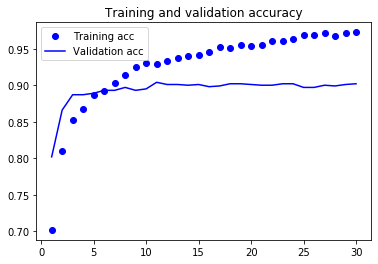

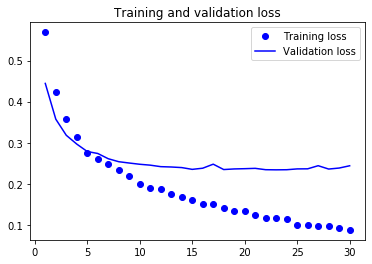

In [8]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend();

The second technique for doing feature extraction, which is much slower and more expensive, but which allows 
us to leverage data augmentation during training: extending the `conv_base` model and running it end-to-end on the inputs. Note that this technique is in fact so expensive that you should only attempt it if you have access to a GPU: it is absolutely intractable on CPU. If you cannot run your code on GPU, then the previous technique is the way to go.